In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from setup_env import setup_environment

setup_environment()

In [3]:
import numpy as np
import pennylane as qml
import pennylane.numpy as pnp
from hsip import HSIP
from superop import superoperator

### Example QNode

In [4]:
def ansatz(params):
    qml.RX(params[0], 0)
    qml.RY(params[1], 1)
    qml.CNOT([0, 1])
    qml.CRX(params[0], [1, 0])
    qml.DepolarizingChannel(0.1, wires=1)
    qml.PhaseFlip(0.2, wires=0)
    qml.IsingXX(params[1], [1, 0])
    qml.Hadamard(1)
    qml.PhaseShift(np.pi / 2, 0)
    qml.AmplitudeDamping(0.3, wires=1)
    qml.PhaseFlip(0.4, wires=0)
    qml.IsingYY(params[2], [1, 0])
    qml.CRZ(params[3], [0, 1])
    qml.IsingZZ(params[0], [1, 0])


H = qml.PauliZ(0)

Expecation value: 0.20643257560335282
(<Figure size 1300x300 with 1 Axes>, <Axes: >)


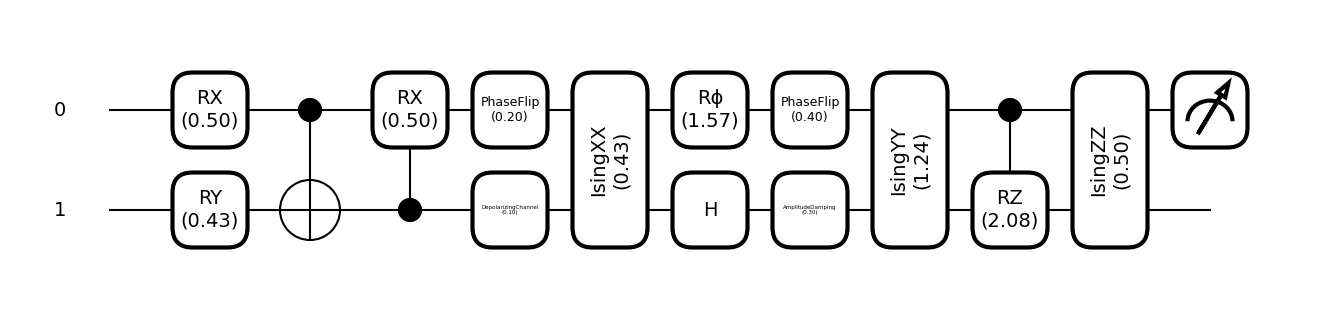

In [5]:
n_qubits = 2
dev = qml.device("default.mixed", wires=n_qubits)


@qml.qnode(dev)
def cost(params):
    ansatz(params)
    return qml.expval(H)


params = pnp.array([0.5, 0.43, 1.24, 2.08], requires_grad=True)
expval = cost(params)
print("Expecation value:", expval)
print(qml.draw_mpl(cost, decimals=2)(params))

### Initial mixed state

In [6]:
from pennylane.devices.qubit import create_initial_state, apply_operation

psi = create_initial_state(range(n_qubits))
plus_state = apply_operation(qml.Hadamard(0) @ qml.Hadamard(1), psi)
rho = qml.math.dm_from_state_vector(psi.flatten())
rho_plus = qml.math.dm_from_state_vector(plus_state.flatten())

initial_rho = 0.3 * rho + 0.7 * rho_plus
initial_rho

array([[0.475+0.j, 0.175+0.j, 0.175+0.j, 0.175+0.j],
       [0.175+0.j, 0.175+0.j, 0.175+0.j, 0.175+0.j],
       [0.175+0.j, 0.175+0.j, 0.175+0.j, 0.175+0.j],
       [0.175+0.j, 0.175+0.j, 0.175+0.j, 0.175+0.j]])

Expecation value: 0.033388644481740726
(<Figure size 1400x300 with 1 Axes>, <Axes: >)


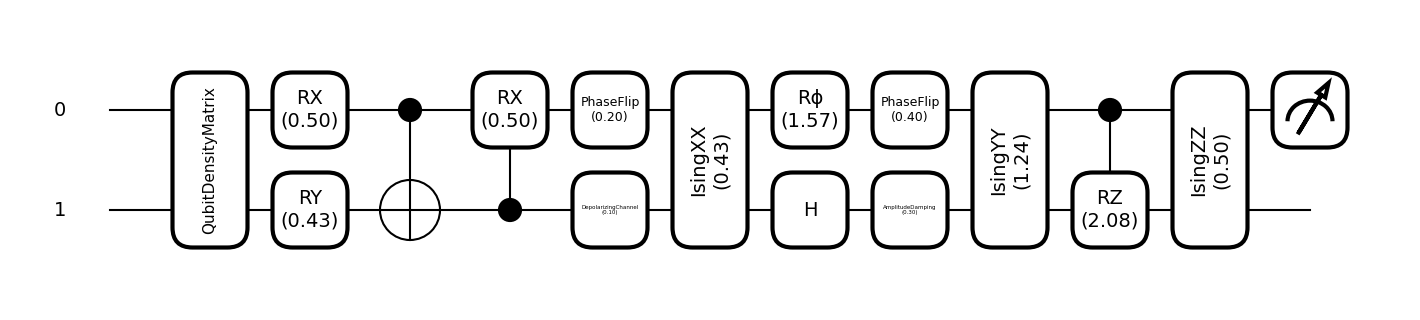

In [7]:
@qml.qnode(dev)
def cost_ims(params):
    qml.QubitDensityMatrix(initial_rho, range(n_qubits))
    ansatz(params)
    return qml.expval(H)


expval_ims = cost_ims(params)
print("Expecation value:", expval_ims)
print(qml.draw_mpl(cost_ims, decimals=2)(params))

### Superoperator Simulation

Expecation value Superop: 0.20643257560335276
(<Figure size 1500x500 with 1 Axes>, <Axes: >)


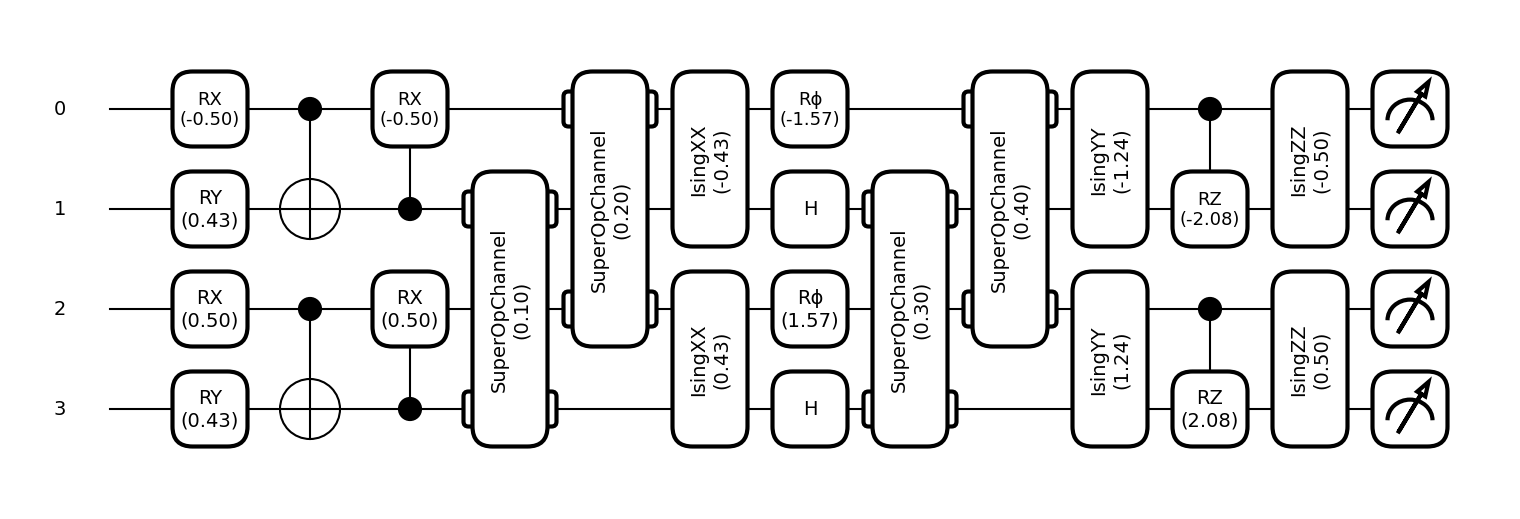

In [12]:
dev_super = qml.device("default.qubit", wires=2 * n_qubits)
measurement = HSIP(H, range(n_qubits)) # Hilbert-Schmidt inner product

@qml.qnode(dev_super)
@superoperator
def qnode_superop(params):
    ansatz(params)
    return qml.state()

def cost_superop(func, params):
    sv = func(params)
    return measurement(sv, range(n_qubits))


expval_superop = cost_superop(qnode_superop, params)
print("Expecation value Superop:", expval_superop)
print(qml.draw_mpl(qnode_superop, decimals=2)(params))

In [13]:
np.allclose(expval, expval_superop)

True

### Initial mixed state in Superoperator Formalism

Expecation value Superop: 0.03338864448174089
(<Figure size 1600x500 with 1 Axes>, <Axes: >)


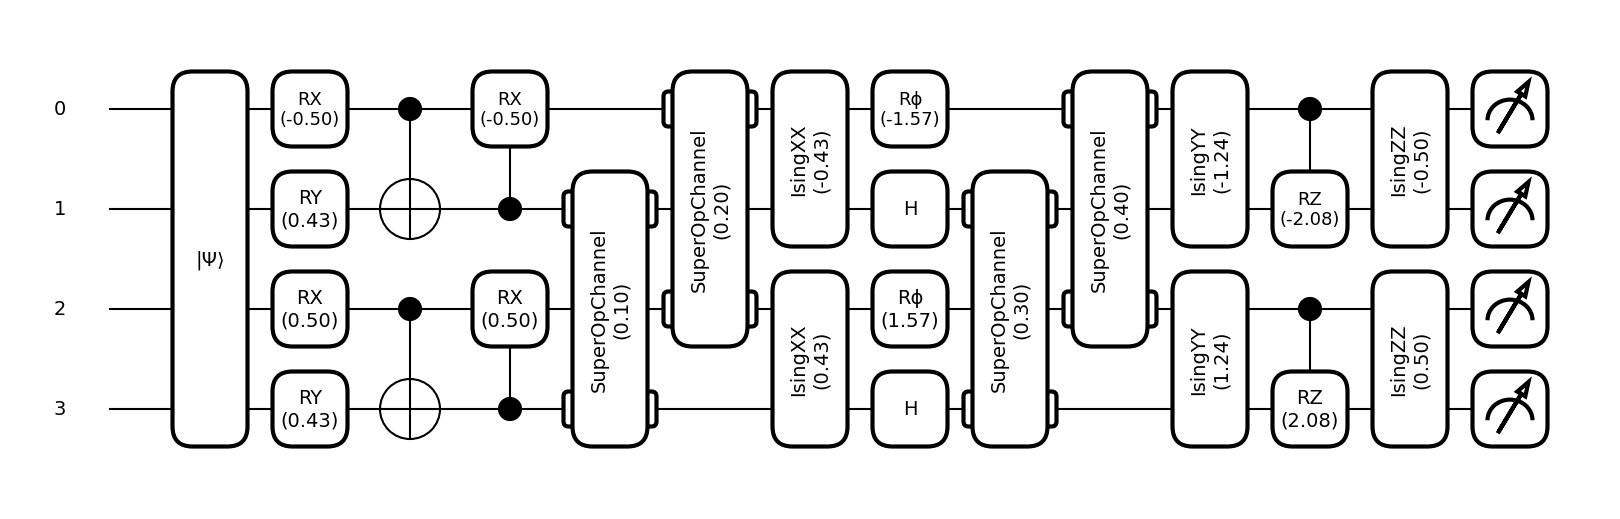

In [14]:
dev_super = qml.device("default.qubit", wires=2 * n_qubits)
measurement = HSIP(H, range(n_qubits))

@qml.qnode(dev_super)
@superoperator(initial_rho=initial_rho)
def qnode_superop_ims(params):
    ansatz(params)
    return qml.state()


expval_superop_ims = cost_superop(qnode_superop_ims, params)
print("Expecation value Superop:", expval_superop_ims)
print(qml.draw_mpl(qnode_superop_ims, decimals=2)(params))

In [15]:
np.allclose(expval_ims, expval_superop_ims)

True